In [ ]:
# import python library for data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_squared_error
scaler= StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# This section was previously made for a kaggle competition by another user. It was adjusted to work with Random Forest Regression.

In [ ]:
# load the data
df_Auser = pd.read_csv(r"Aquifer_Auser.csv")

# set date as index
df_Auser['Date'] = pd.to_datetime(df_Auser['Date'],format='%d/%m/%Y', errors='ignore')
df_Auser = df_Auser.set_index('Date')
df_Auser.shape

(8154, 26)

Determine Missing Data Percentage

In [ ]:
def get_percentage_nan_values(data, thresh=20, color='black', edgecolor='black', width=15, height=3):

    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh} missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')

    return plt.show()

def show_distribution_nan_values(df):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
    sns.heatmap(df.T.isna(), cmap='Blues')
    ax.set_title('Fields with Missing Values', fontsize=16)
    #for tick in ax.xaxis.get_major_ticks():
    #    tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    return plt.show()

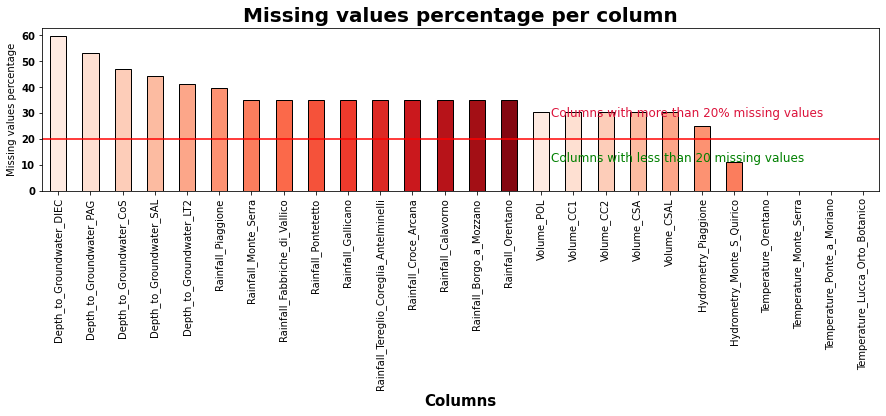

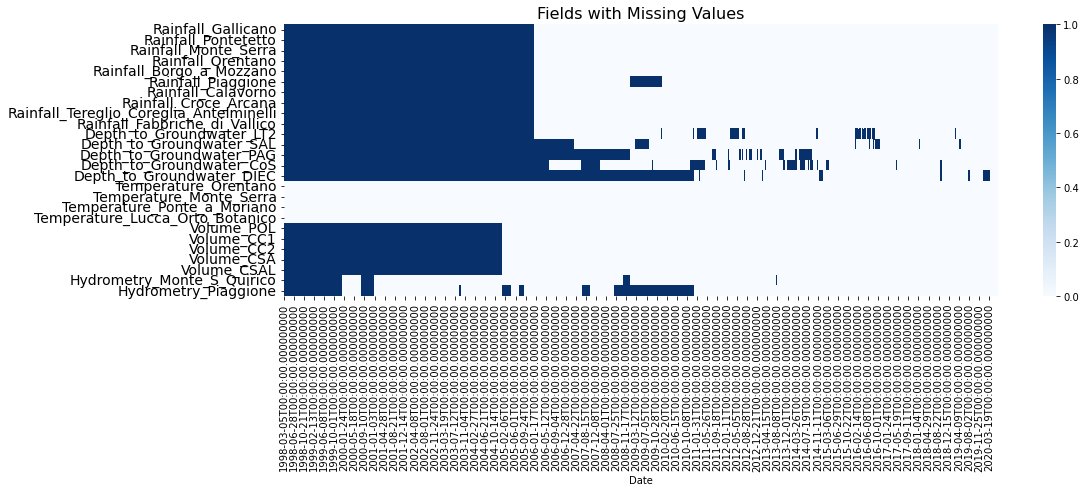

In [ ]:
# show percentage and distribution missing values per columns
get_percentage_nan_values(df_Auser, 20, color=sns.color_palette('Reds',15))
show_distribution_nan_values(df_Auser)

We can see that starting at 2006 data was more regularly taken, that would be a good starting point.

In [ ]:
# select data after 2006-01-01
df_Auser = df_Auser[df_Auser.index >='2006-01-01']

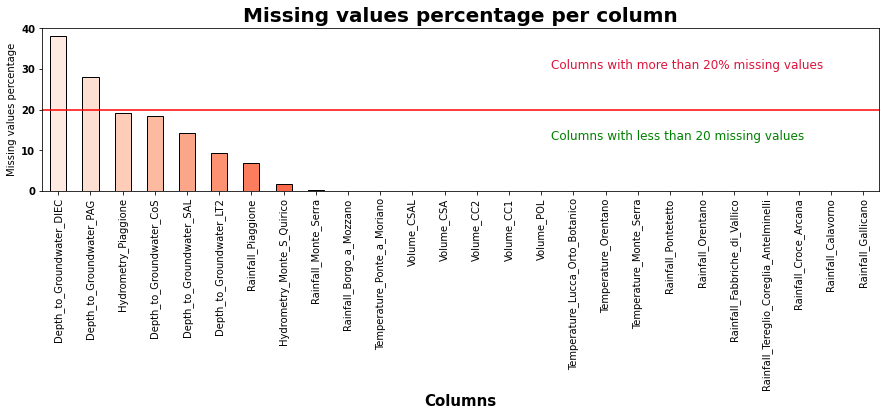

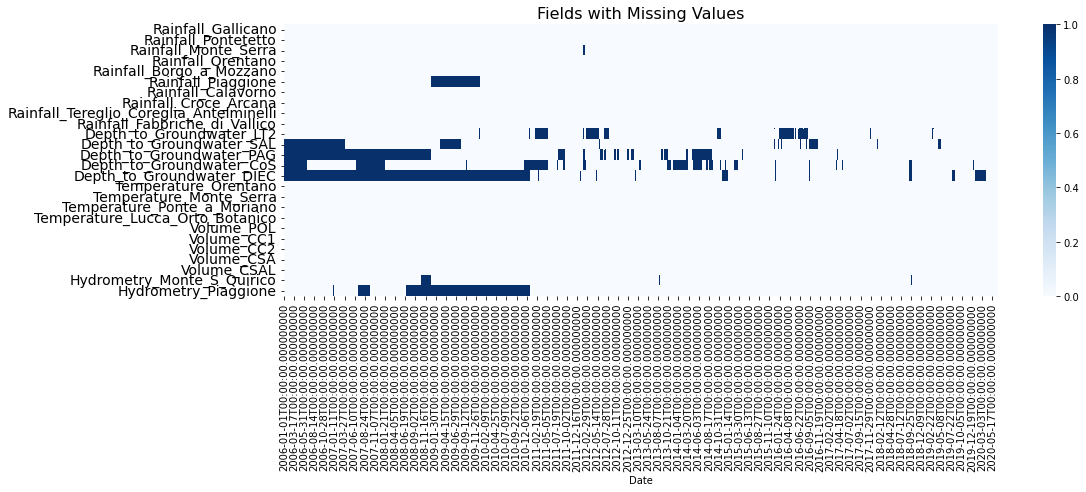

In [ ]:
# look at the percentage and distribution of the missing value
get_percentage_nan_values(df_Auser, 20, color=sns.color_palette('Reds',15))
show_distribution_nan_values(df_Auser)

Now lets clean the data in order to remove any missing or nan values

In [ ]:
# get columns names
df_Auser.columns

Index(['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra',
       'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione',
       'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli',
       'Rainfall_Fabbriche_di_Vallico', 'Depth_to_Groundwater_LT2',
       'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
       'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC',
       'Temperature_Orentano', 'Temperature_Monte_Serra',
       'Temperature_Ponte_a_Moriano', 'Temperature_Lucca_Orto_Botanico',
       'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL',
       'Hydrometry_Monte_S_Quirico', 'Hydrometry_Piaggione'],
      dtype='object')

Remove missing data noted with 'zero'


In [ ]:
# REPLACE missing value noted with '0' by the previous data
df_Auser['Depth_to_Groundwater_LT2'] = df_Auser['Depth_to_Groundwater_LT2'].replace(to_replace=0, method='ffill')
df_Auser['Depth_to_Groundwater_CoS'] = df_Auser['Depth_to_Groundwater_CoS'].replace(to_replace=0.00, method='ffill')
df_Auser['Depth_to_Groundwater_SAL'] = df_Auser['Depth_to_Groundwater_SAL'].replace(to_replace=0, method='ffill')
df_Auser['Depth_to_Groundwater_DIEC'] = df_Auser['Depth_to_Groundwater_DIEC'].replace(to_replace=0, method='ffill')

Remove missing data noted with 'Nan'


In [ ]:
# create two column with the month and the year
df_Auser['Month'] = pd.DatetimeIndex(df_Auser.index).month
df_Auser['Year'] = pd.DatetimeIndex(df_Auser.index).year

# replace nan value by the mean of the month of the year
df_Auser.fillna(df_Auser.groupby(['Month','Year']).transform('mean'), inplace=True)

# Then if missing value  still present:
# replace nan value by the mean of the month calculated over the entire dataframe
df_Auser.fillna(df_Auser.groupby(['Month']).transform('mean'), inplace=True)

Remove suspicious data observed in 2020




In [ ]:
# select the last 14 years only
df_Auser = df_Auser[df_Auser.index <='2020-01-01']

Drop other unneeded columns

In [ ]:
df_Auser = df_Auser.drop(columns=['Month','Year','Depth_to_Groundwater_PAG','Depth_to_Groundwater_DIEC','Volume_POL','Volume_CC1','Volume_CC2','Volume_CSA','Volume_CSAL'])

Feature engineering

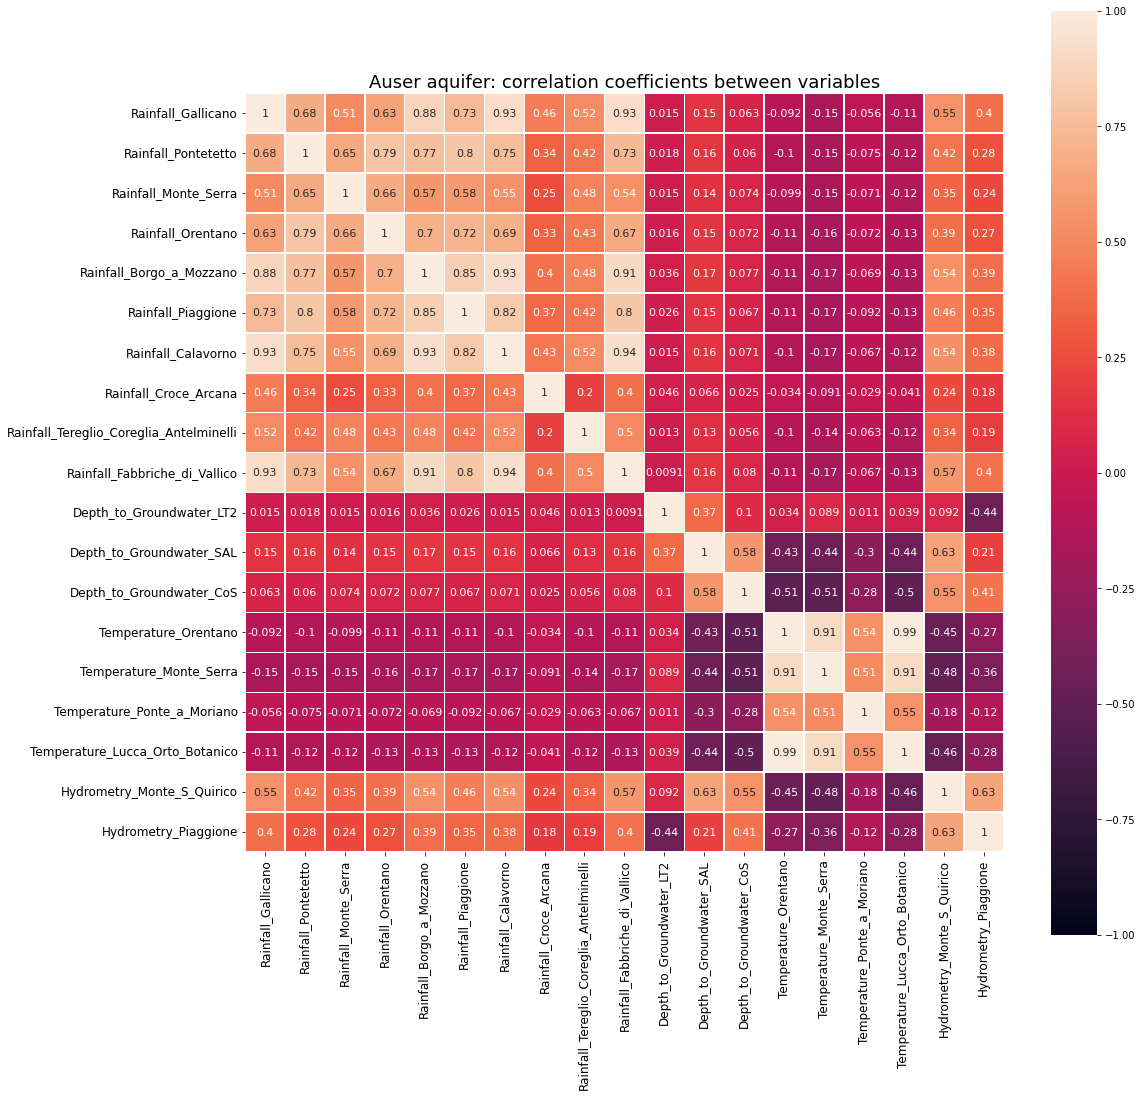

In [ ]:
corr = df_Auser.corr(method='pearson')

fig, ax = plt.subplots(figsize=(17,17))

ax = sns.heatmap(corr,annot=True,linewidths=.5, annot_kws={"size": 11},vmin=-1.0, vmax=1.0,square=True,cbar=True)
ax.set_title('Auser aquifer: correlation coefficients between variables',size=18,y=1.05)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,size=12)
plt.show()

#This Section Is Entirely Personal Work:

We can see the correlations between effective rainfall and groundwater levels are slightly better than the correlation coefficients between mean rainfall and groundwater levels. So we'll be using effective rainfall and groundwater levels as our inputs.

Using Random Forests

Training score: 0.9814839186021003
Mean value: 0.23665830810933014
Training score: 0.9704103282529828
Mean value: 0.18080123028229786
Training score: 0.971168748920903
Mean value: 0.4046264352023836


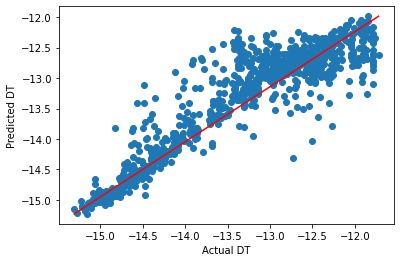

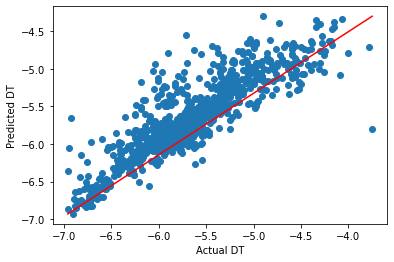

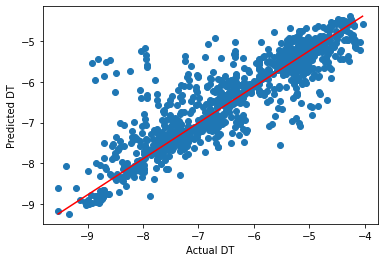

In [ ]:
X = df_Auser.drop(["Depth_to_Groundwater_LT2", "Depth_to_Groundwater_SAL", "Depth_to_Groundwater_CoS"], axis=1)
Y = np.array([df_Auser["Depth_to_Groundwater_LT2"], df_Auser["Depth_to_Groundwater_SAL"], df_Auser["Depth_to_Groundwater_CoS"]])
for i in range(0, 3):
  y = Y[i]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 44)
  rf_model = RandomForestRegressor(n_estimators = 100)
  rf_model.fit(X_train, y_train)

  y_pred = rf_model.predict(X_test)
  mean = metrics.mean_absolute_error(y_test, y_pred)
  score = rf_model.score(X_train, y_train)
  print("Training score:", score)
  print("Mean value:", mean)
  plt.figure(i)
  plt.scatter(y_test, y_pred)
  plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_pred), np.max(y_pred)],color = 'red')
  plt.ylabel('Predicted DT')
  plt.xlabel('Actual DT')
  plt.plot()

Multioutputregression Random Forests

In [ ]:
X = df_Auser.drop(["Depth_to_Groundwater_LT2", "Depth_to_Groundwater_SAL", "Depth_to_Groundwater_CoS"], axis=1)
y = np.array([df_Auser["Depth_to_Groundwater_LT2"],df_Auser["Depth_to_Groundwater_SAL"],df_Auser["Depth_to_Groundwater_CoS"]]).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=44)

regr_multirf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, random_state=0)
)
regr_multirf.fit(X_train, y_train)

y_multirf = regr_multirf.predict(X_test)
y_multirf.shape

(1023, 3)

Training score: 0.8003476881330277
Mean value: 0.27424604222054777


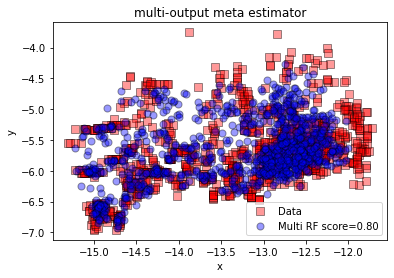

In [ ]:
plt.figure()
s = 50
a = 0.4
plt.scatter(
    y_test[:, 0],
    y_test[:, 1],
    edgecolor="k",
    c="red",
    s=s,
    marker="s",
    alpha=a,
    label="Data",
)
plt.scatter(
    y_multirf[:, 0],
    y_multirf[:, 1],
    edgecolor="k",
    c="blue",
    s=s,
    alpha=a,
    label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test),
)

mean = metrics.mean_absolute_error(y_test, y_multirf)
score = regr_multirf.score(X_test, y_test)
print("Training score:", score)
print("Mean value:", mean)
plt.xlabel("x")
plt.ylabel("y")
plt.title("multi-output meta estimator")
plt.legend()
plt.show()